# LFC Data Analysis: The LFC Goal Machine 

This notebook analyses Liverpool FC's goal scorers, in particular exploring a scatter plot of player's age against top level league goals scored. The plot is available as an interactive web app called the LFC Goal Machine [here](http://http://lfcgm.herokuapp.com/). 

The notebook describes some interesting plots and describes how the app was built and deployed.

The project uses [IPython Notebook](http://ipython.org/notebook.html), [python](https://www.python.org/), [pandas](http://pandas.pydata.org/), [matplotlib](http://matplotlib.org/), [numpy](http://www.numpy.org/), [ggplot](http://ggplot.yhathq.com/), [spyre](https://github.com/adamhajari/spyre), [heroku](https://www.heroku.com/) and [heroku scipy buildpack](https://github.com/thenovices/heroku-buildpack-scipy).


#### Notebook Change Log

In [4]:
%%html
<! left align the change log table in next cell >
<style>
table {float:left}
</style>

| Date          | Change Description |
| :------------ | :----------------- |
| 21st February 2016 | Initial baseline |
| 30th October 2016 | Added season 2015-16 |

## Set-up

Import the modules needed for the analysis.

In [5]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sys
import collections
import os
from ggplot import *
from ggplot import __version__ as ggplot_version
from datetime import datetime
from __future__ import division

# enable inline plotting
%matplotlib inline

Print version numbers.

In [6]:
print 'python version: {}'.format(sys.version)
print 'pandas version: {}'.format(pd.__version__)
print 'matplotlib version: {}'.format(mpl.__version__)
print 'numpy version: {}'.format(np.__version__)
print 'ggplot version: {}'.format(ggplot_version)

python version: 2.7.11 |Anaconda 4.0.0 (64-bit)| (default, Feb 16 2016, 09:58:36) [MSC v.1500 64 bit (AMD64)]
pandas version: 0.18.0
matplotlib version: 1.5.1
numpy version: 1.11.1
ggplot version: 0.6.8


## Load the LFC data into dataframes and munge

#### Create a dataframe of scorers in top level league seasons
Data source: lfchistory.net

In [8]:
LFC_SCORERS_CSV_FILE = os.path.relpath('data/lfc_scorers_1892-1893_2015-2016.csv')
dflfc_scorers = pd.read_csv(LFC_SCORERS_CSV_FILE)

# sort by season, then league goals
dflfc_scorers = dflfc_scorers.sort_values(['season', 'league'], ascending=([False, False]))
dflfc_scorers.shape

(1416, 3)

In [9]:
dflfc_scorers.head()

,season,player,league
1400,2015-2016,Roberto Firmino,10
1401,2015-2016,Christian Benteke,9
1398,2015-2016,Daniel Sturridge,8
1399,2015-2016,Philippe Coutinho,8
1402,2015-2016,Divock Origi,5


In [10]:
dflfc_scorers.tail()

,season,player,league
5,1892-1893,Jonathan Cameron,4
6,1892-1893,Jim McBride,4
7,1892-1893,Hugh McQueen,3
9,1892-1893,Joe McQue,2
8,1892-1893,Own goals,1


In [11]:
# note that scorers includes own goals
dflfc_scorers[dflfc_scorers.player == 'Own goals'].head()

,season,player,league
1411,2015-2016,Own goals,1
1388,2014-2015,Own goals,4
1374,2013-2014,Own goals,5
1356,2012-2013,Own goals,4
1343,2011-2012,Own goals,5


In [12]:
# note: war years already excluded
LANCS_YRS = ['1892-1893']
SECOND_DIV_YRS = ['1893-1894', '1895-1896', '1904-1905', '1961-1962', 
                  '1954-1955', '1955-1956', '1956-1957', '1957-1958', 
                  '1958-1959', '1959-1960', '1960-1961']

NOT_TOP_LEVEL_YRS = LANCS_YRS + SECOND_DIV_YRS
dflfc_scorers_tl = dflfc_scorers[~dflfc_scorers.season.isin(NOT_TOP_LEVEL_YRS)].copy()
dflfc_scorers_tl.shape

(1268, 3)

In [14]:
## check number of top level seasons aligns with http://www.lfchistory.net/Stats/LeagueOverall.aspx
## expect 101 total 1894-95 to 2015-16
print 'the number of seasons is {}'.format(len(dflfc_scorers_tl.season.unique()))

the number of seasons is 101


In [15]:
# show most league goals in a season in top level
# cross-check with http://en.wikipedia.org/wiki/List_of_Liverpool_F.C._records_and_statistics#Goalscorers
# expect 101 in 2013-14
dflfc_scorers_tl[['season', 'league']].groupby(['season']).sum().sort_values('league', ascending=False).head(1)

,league
season,
2013-2014,101


In [16]:
# remove OG
dflfc_scorers_tl = dflfc_scorers_tl[dflfc_scorers_tl.player != 'Own goals']
dflfc_scorers_tl.shape

(1198, 3)

In [35]:
# check 2015-16
dflfc_scorers_tl[dflfc_scorers_tl.season == '2015-2016'].head(10)

,season,player,league
1400,2015-2016,Roberto Firmino,10
1401,2015-2016,Christian Benteke,9
1398,2015-2016,Daniel Sturridge,8
1399,2015-2016,Philippe Coutinho,8
1402,2015-2016,Divock Origi,5
1403,2015-2016,James Milner,5
1404,2015-2016,Adam Lallana,4
1406,2015-2016,Joe Allen,2
1407,2015-2016,Danny Ings,2
1410,2015-2016,Jordan Henderson,2


#### Create dataframe of squads giving the position of each player
Data source: lfchistory.net

In [36]:
LFC_SQUADS_CSV_FILE = os.path.relpath('data/lfc_squads_1892-1893_2015-2016.csv')
dflfc_squads = pd.read_csv(LFC_SQUADS_CSV_FILE)
dflfc_squads.shape

(2944, 3)

In [37]:
dflfc_squads.head()

,season,player,position
0,1892-1893,Sydney Ross,Goalkeeper
1,1892-1893,Billy McOwen,Goalkeeper
2,1892-1893,Jim McBride,Defender
3,1892-1893,John McCartney,Defender
4,1892-1893,Andrew Hannah,Defender


In [38]:
dflfc_squads.tail()

,season,player,position
2939,2015-2016,Daniel Sturridge,Striker
2940,2015-2016,Divock Origi,Striker
2941,2015-2016,Danny Ings,Striker
2942,2015-2016,Christian Benteke,Striker
2943,2015-2016,Jerome Sinclair,Striker


#### Create dataframe of LFC's league position
Data source: lfchistory.net

In [39]:
LFC_LEAGUE_CSV_FILE = os.path.relpath('data/lfc_league_1893-1894_2015-2016.csv')
dflfc_league = pd.read_csv(LFC_LEAGUE_CSV_FILE)
dflfc_league.shape

(113, 18)

In [40]:
dflfc_league.head()

,Season,League,Pos,PLD,HW,HD,HL,HF,HA,AW,AD,AL,AF,AA,PTS,GF,GA,GD
0,1893-1894,2nd Division,1,28,14,0,0,46,6,8,6,0,31,12,50,77,18,59
1,1894-1895,1st Division,15,30,6,4,5,38,28,1,4,10,13,42,22,51,70,-19
2,1895-1896,2nd Division,1,30,14,1,0,65,11,8,1,6,41,21,46,106,32,74
3,1896-1897,1st Division,5,30,7,6,2,25,10,5,3,7,21,28,33,46,38,8
4,1897-1898,1st Division,9,30,7,4,4,27,16,4,2,9,21,29,28,48,45,3


In [41]:
dflfc_league.tail()

,Season,League,Pos,PLD,HW,HD,HL,HF,HA,AW,AD,AL,AF,AA,PTS,GF,GA,GD
108,2011-2012,Premier League,8,38,6,9,4,24,16,8,1,10,23,24,52,47,40,7
109,2012-2013,Premier League,7,38,9,6,4,33,16,7,7,5,38,27,61,71,43,28
110,2013-2014,Premier League,2,38,16,1,2,53,18,10,5,4,48,32,84,101,50,51
111,2014-2015,Premier League,6,38,10,5,4,30,20,8,3,8,22,28,62,52,48,4
112,2015-2016,Premier League,8,38,8,8,3,33,22,8,4,7,30,28,60,63,50,13


#### Create merged dataframe, combining scorers in top league level season with squad position

In [42]:
dflfc_scorers_tl_pos = pd.DataFrame.merge(dflfc_scorers_tl, dflfc_squads)
dflfc_scorers_tl_pos.shape

(1198, 4)

In [43]:
dflfc_scorers_tl_pos.head()

,season,player,league,position
0,2015-2016,Roberto Firmino,10,Striker
1,2015-2016,Christian Benteke,9,Striker
2,2015-2016,Daniel Sturridge,8,Striker
3,2015-2016,Philippe Coutinho,8,Midfielder
4,2015-2016,Divock Origi,5,Striker


In [44]:
dflfc_scorers_tl_pos.tail()

,season,player,league,position
1193,1894-1895,Frank Becton,4,Striker
1194,1894-1895,Neil Kerr,3,Midfielder
1195,1894-1895,Hugh McQueen,2,Midfielder
1196,1894-1895,Joe McQue,1,Defender
1197,1894-1895,Patrick Gordon,1,Midfielder


#### Create a dataframe of players with birthdate and country of birth

In [45]:
LFC_PLAYERS_CSV_FILE = os.path.relpath('data/lfc_players_april2016_upd.csv')
dflfc_players = pd.read_csv(LFC_PLAYERS_CSV_FILE, parse_dates=['birthdate'])
dflfc_players.shape

(765, 3)

In [46]:
dflfc_players.head()

,player,birthdate,country
0,Gary Ablett,1965-11-19,England
1,Alan A'Court,1934-09-30,England
2,Charlie Adam,1985-12-10,Scotland
3,Daniel Agger,1984-12-12,Denmark
4,Andrew Aitken,1909-08-25,England


In [47]:
dflfc_players.tail()

,player,birthdate,country
760,Ron Yeats,1937-11-15,Scotland
761,Samed Yesil,1994-05-25,Germany
762,Tommy Younger,1930-04-10,Scotland
763,Bolo Zenden,1976-08-15,Netherlands
764,Christian Ziege,1972-02-01,Germany


#### Create merged dataframe of players, combining scorers in top league level season with squad position and age

Add players age to the dflfc_scorers_tl_pos dataframe

In [48]:
def age_at_season(row):
    """Return player's age at mid-point of season, assumed to be 1st Jan.
    
        row.player -> player's name
        row.season -> season
        
        uses dflfc_players to look-up birthdate, keyed on player
         - return average age if player is missing from dflfc_players
    """
    
    AVERAGE_AGE = 26.5
    
    mid_point = '01 January {}'.format(row.season[-4:])
    try:
        dob = dflfc_players[dflfc_players.player == row.player].birthdate.values[0]
    except:
        # use average age if player's birthdate not available
        print 'error: age not found for player {} in season {}, using average age {}'.format(row.player, 
                                                                                             row.season, 
                                                                                             AVERAGE_AGE)
        return AVERAGE_AGE
    return round((pd.Timestamp(mid_point) - dob).days/365.0, 1)

In [49]:
# add age column
dflfc_scorers_tl_pos['age'] = dflfc_scorers_tl_pos.apply(lambda row: age_at_season(row), axis=1)

error: age not found for player William Walker in season 1897-1898, using average age 26.5


In [50]:
dflfc_scorers_tl_pos_age = dflfc_scorers_tl_pos.copy()

In [52]:
dflfc_scorers_tl_pos_age.head()

,season,player,league,position,age
0,2015-2016,Roberto Firmino,10,Striker,24.3
1,2015-2016,Christian Benteke,9,Striker,25.1
2,2015-2016,Daniel Sturridge,8,Striker,26.4
3,2015-2016,Philippe Coutinho,8,Midfielder,23.6
4,2015-2016,Divock Origi,5,Striker,20.7


##### Save the new dataframe

This is the key dataframe used in the plot of age vs league goals.

In [53]:
LFC_SCORERS_TL_POS_AGE_FILE = os.path.relpath('data/lfc_scorers_tl_pos_age.csv')
dflfc_scorers_tl_pos_age.to_csv(LFC_SCORERS_TL_POS_AGE_FILE, header=True, sep=',')

#### Create dataframe of player's league appearances

In [58]:
# read the appearance file
LFC_LGAPPS_CSV_FILE = os.path.relpath('data/lfc_apps_1892-93_2015-16.csv')
dflfc_lgapps = pd.read_csv(LFC_LGAPPS_CSV_FILE)
print dflfc_lgapps.shape
dflfc_lgapps.head()

(2585, 3)


,season,player,lgapp
0,1892-1893,Andrew Hannah,22
1,1892-1893,Duncan McLean,22
2,1892-1893,Tom Wyllie,22
3,1892-1893,Malcolm McVean,21
4,1892-1893,John Miller,21


#### Create merged dataframe of players, combining scorers in top league level season with squad position, age and appearances

In [59]:
dflfc_scorers_tl_pos_age_apps = dflfc_scorers_tl_pos_age.merge(dflfc_lgapps)
print dflfc_scorers_tl_pos_age_apps.shape
print dflfc_scorers_tl_pos.shape

(1198, 6)
(1198, 5)


In [60]:
dflfc_scorers_tl_pos_age_apps.head()

,season,player,league,position,age,lgapp
0,2015-2016,Roberto Firmino,10,Striker,24.3,31
1,2015-2016,Christian Benteke,9,Striker,25.1,29
2,2015-2016,Daniel Sturridge,8,Striker,26.4,14
3,2015-2016,Philippe Coutinho,8,Midfielder,23.6,26
4,2015-2016,Divock Origi,5,Striker,20.7,16


In [61]:
dflfc_scorers_tl_pos_age_apps.tail()

,season,player,league,position,age,lgapp
1193,1894-1895,Frank Becton,4,Striker,21.2,5
1194,1894-1895,Neil Kerr,3,Midfielder,23.7,12
1195,1894-1895,Hugh McQueen,2,Midfielder,27.3,12
1196,1894-1895,Joe McQue,1,Defender,21.8,29
1197,1894-1895,Patrick Gordon,1,Midfielder,24.9,5


## Analyse the data

Ask a question and find the answer!

#### Create a function to plot player's age vs top level league goals

In [62]:
def ggplot_age_vs_lgoals(df, players):
    """Return ggplot of Age vs League Goals for given list of players in dataframe.

       Given the low number of points, ggplot's geom_smooth uses
       the loess method with default span."""
    TITLE = 'LFCGM Age vs League Goals'
    XLABEL = 'Age at Midpoint of Season'
    YLABEL = 'League Goals per Season'
    EXEMPLAR_PLAYERS = ['Ian Rush', 'Kenny Dalglish', 'Roger Hunt', 'David Johnson',
                        'Harry Chambers', 'John Toshack', 'John Barnes', 'Kevin Keegan']
    EXEMPLAR_TITLE = 'LFCGM Example Plot, The Champions: Age vs League Goals'

    # if players list is empty then set the default exemplar options
    if not players:
        players = EXEMPLAR_PLAYERS
        TITLE = EXEMPLAR_TITLE

    # fiter dataframe for given players and plot
    this_df = df[df.player.isin(players)]
    this_plot = ggplot(this_df, aes(x='age', y='league', color='player', shape='player')) + \
                    geom_point() + \
                    geom_smooth(se=False) + \
                    xlab(XLABEL) + \
                    ylab(YLABEL) + \
                    scale_y_discrete(limits=(0, this_df.league.max() + 1)) + \
                    ggtitle(TITLE)
    return this_plot

C:\Users\Terry_2\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
C:\Users\Terry_2\Anaconda\lib\site-packages\ggplot\stats\stat_smooth.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  data = data.sort(['x'])


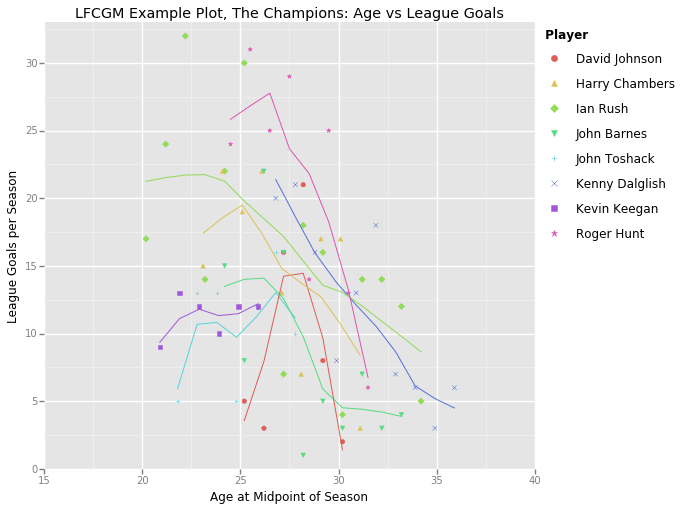

<ggplot: (11899557)>

In [63]:
# show the default plot, showing the champions (see below for more info on 'The Champions')
players = []
ggplot_age_vs_lgoals(dflfc_scorers_tl_pos_age, players)

In [64]:
# show type of gglplot.draw() object
# Note that Spyre (v0.2) can only handle matplotlib object or pyplot figure
players = []
ggp = ggplot_age_vs_lgoals(dflfc_scorers_tl_pos_age, players)
type(ggp.draw())

matplotlib.figure.Figure

#### Show some interesting plots

Early Riser

In [65]:
# show all players scoring more than 20 goals when under 20 years old
dflfc_scorers_tl_pos_age[(dflfc_scorers_tl_pos_age.league >= 20) & 
                          (dflfc_scorers_tl_pos_age.age < 20)]

,season,player,league,position,age
273,1994-1995,Robbie Fowler,25,Striker,19.7


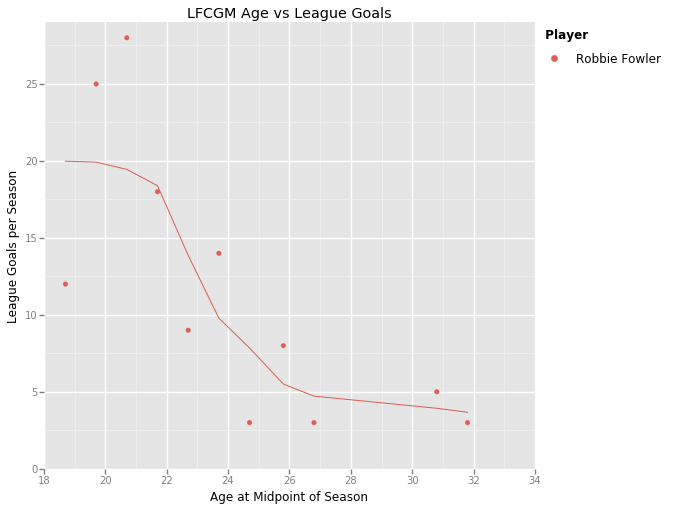

<ggplot: (11504283)>

In [67]:
# produce plot for player known as 'god'
players = ['Robbie Fowler']
ggplot_age_vs_lgoals(dflfc_scorers_tl_pos_age, players)

Late Flourish

In [68]:
# show all players scoring more than 20 goals when over 30 years old
df_late = dflfc_scorers_tl_pos_age[(dflfc_scorers_tl_pos_age.league >= 20) & 
                                   (dflfc_scorers_tl_pos_age.age > 30)]
df_late

,season,player,league,position,age
348,1988-1989,John Aldridge,21,Striker,30.3
754,1946-1947,Jack Balmer,24,Striker,30.9
802,1934-1935,Gordon Hodgson,27,Striker,30.7
910,1925-1926,Dick Forshaw,27,Striker,30.4
1055,1908-1909,Ronald Orr,20,Striker,32.4


['Dick Forshaw', 'Gordon Hodgson', 'Jack Balmer', 'John Aldridge', 'Ronald Orr']


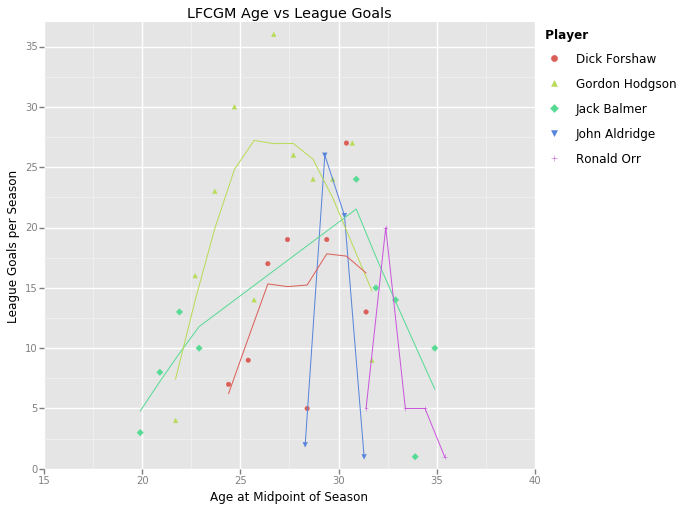

<ggplot: (14968640)>

In [69]:
players = df_late.player.values
print sorted(players)
ggplot_age_vs_lgoals(dflfc_scorers_tl_pos_age, list(players))

All time career top scorers

In [70]:
# show players scoring most league goals over their career
df_top = dflfc_scorers_tl_pos_age[['player', 'league']].groupby('player').sum()
df_top = df_top.sort_values('league', ascending=False).head(12)
df_top

,league
player,
Gordon Hodgson,233
Ian Rush,229
Roger Hunt,167
Harry Chambers,135
Robbie Fowler,128
Steven Gerrard,120
Kenny Dalglish,118
Michael Owen,118
Dick Forshaw,116


['Gordon Hodgson' 'Ian Rush' 'Roger Hunt' 'Harry Chambers' 'Robbie Fowler'
 'Steven Gerrard']


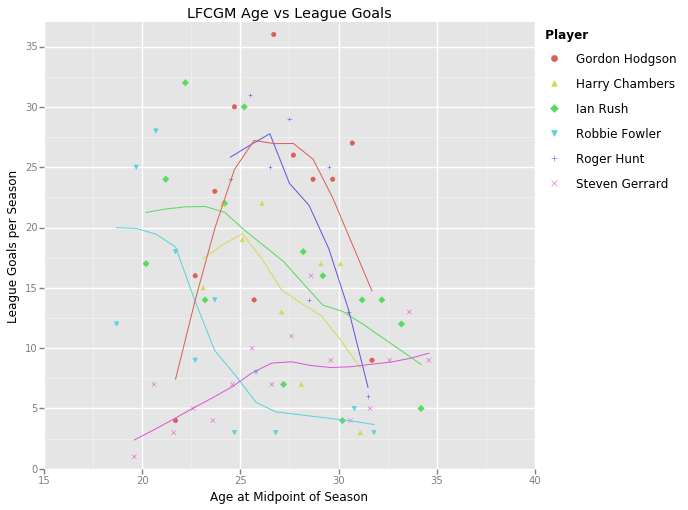

<ggplot: (15173769)>

In [71]:
players = df_top[df_top.league >= 120].index.values
print players
ggplot_age_vs_lgoals(dflfc_scorers_tl_pos_age, list(players))

Elite 30

In [72]:
# show players scoring >=30 league goals in a season
df_elite = dflfc_scorers_tl_pos_age[['season', 'player', 'league']].sort_values('league', ascending=False)
df_elite.head(10)

,season,player,league
849,1930-1931,Gordon Hodgson,36
405,1983-1984,Ian Rush,32
654,1963-1964,Roger Hunt,31
32,2013-2014,Luis Suarez,31
1116,1902-1903,Sam Raybould,31
368,1986-1987,Ian Rush,30
1045,1909-1910,Jack Parkinson,30
875,1928-1929,Gordon Hodgson,30
627,1965-1966,Roger Hunt,29
263,1995-1996,Robbie Fowler,28


['Gordon Hodgson' 'Ian Rush' 'Roger Hunt' 'Luis Suarez' 'Sam Raybould']


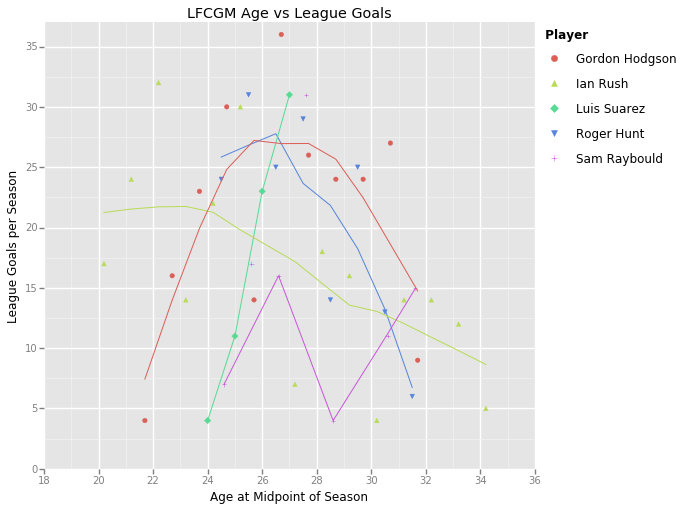

<ggplot: (14967433)>

In [73]:
players = df_elite[df_elite.league > 30].player.unique()
print players
ggplot_age_vs_lgoals(dflfc_scorers_tl_pos_age, list(players))

A Striking Trio
- For a discusson of Liverpool's best ever trio see Terry's blog [A Striking Trio](http://www.lfcsorted.com/2015/07/lfc-striking-trio.html)

In [74]:
# show best total for a striking trio in the league
df_trio = dflfc_scorers_tl_pos_age[['season', 'league']].groupby('season').head(3).groupby('season').sum()
df_trio.sort_values('league', ascending=False).head(10)

,league
season,
1963-1964,67
2013-2014,65
1930-1931,60
1909-1910,60
1946-1947,58
1934-1935,56
1987-1988,56
1931-1932,56
1928-1929,55


In [75]:
TOP_TRIO = ['1963-1964']
df_trio_players = dflfc_scorers_tl_pos_age[['season', 'player', 'league']]\
                                            [dflfc_scorers_tl_pos_age.season.isin(TOP_TRIO)].groupby('season').head(3)
df_trio_players

,season,player,league
654,1963-1964,Roger Hunt,31
655,1963-1964,Ian St John,21
656,1963-1964,Alf Arrowsmith,15


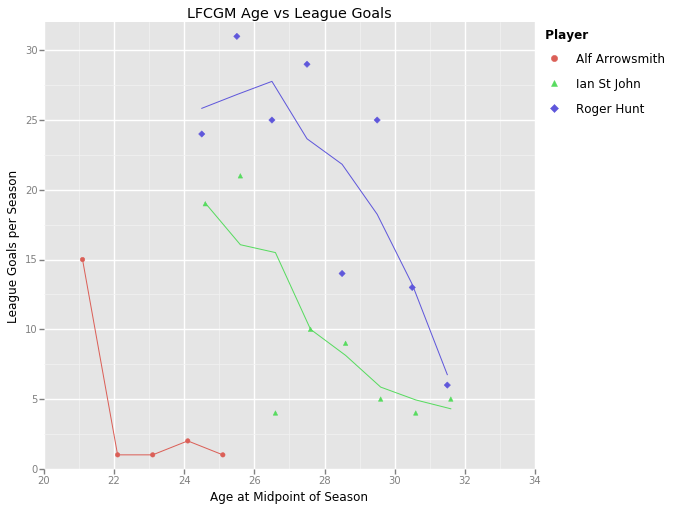

<ggplot: (15093894)>

In [76]:
players = df_trio_players.player.values
ggplot_age_vs_lgoals(dflfc_scorers_tl_pos_age, list(players))

A Striking Duo

In [77]:
# show best total for a striking trio in the league
df_duo = dflfc_scorers_tl_pos_age[['season', 'league']].groupby('season').head(2).groupby('season').sum()
df_duo.sort_values('league', ascending=False).head(10)

,league
season,
2013-2014,52
1963-1964,52
1930-1931,50
1946-1947,48
1909-1910,48
1928-1929,46
1934-1935,46
1925-1926,44
1962-1963,43


In [78]:
TOP_DUO = ['1963-1964', '2013-2014']
df_duo_players = dflfc_scorers_tl_pos_age[['season', 'player', 'league']]\
                                            [dflfc_scorers_tl_pos_age.season.isin(TOP_DUO)].groupby('season').head(2)
df_duo_players

,season,player,league
32,2013-2014,Luis Suarez,31
33,2013-2014,Daniel Sturridge,21
654,1963-1964,Roger Hunt,31
655,1963-1964,Ian St John,21


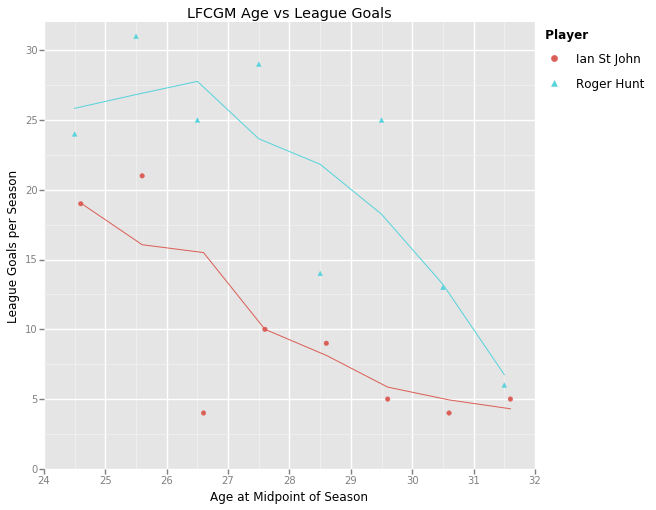

<ggplot: (14920989)>

In [79]:
# plot first of TOP_DUO seasons
players = df_duo_players[df_duo_players.season == TOP_DUO[0]].player.values
ggplot_age_vs_lgoals(dflfc_scorers_tl_pos_age, list(players))

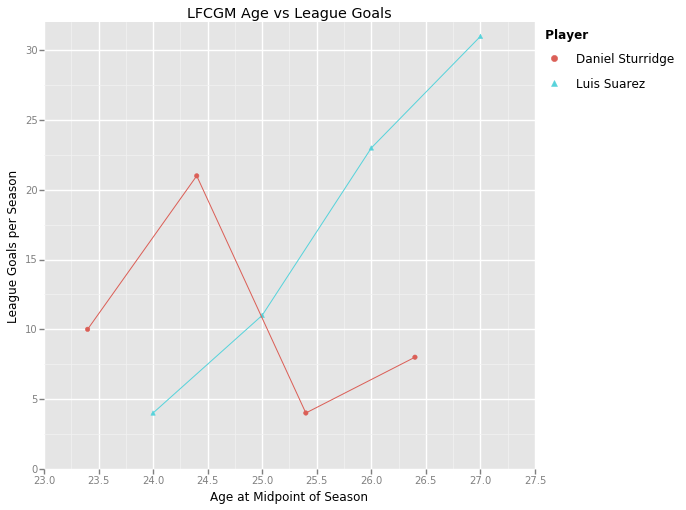

<ggplot: (11602713)>

In [80]:
# plot second of TOP_DUO seasons
players = df_duo_players[df_duo_players.season == TOP_DUO[1]].player.values
ggplot_age_vs_lgoals(dflfc_scorers_tl_pos_age, list(players))

Performance of Liverpool players who went in to be managers

In [81]:
# produce list of managers - ref: http://www.lfchistory.net/Managers/
MANAGERS = ['William Barclay', 'Tom Watson', 'David Ashworth', 'Matt McQueen', 'George Patterson',\
    'George Kay', 'Don Welsh', 'Phil Taylor', 'Bill Shankly', 'Bob Paisley', 'Joe Fagan',\
    'Kenny Dalglish', 'Graeme Souness', 'Roy Evans', 'Gerard Houllier',\
    'Rafael Benitez', 'Roy Hodgson', 'Kenny Dalglish', 'Brendan Rodgers', 'Jurgen Klopp']
# excludes Ronnie Moran who was temporary manager in 1991

In [82]:
# produce list of players (who scored in more than 1 season at top level) who were managers
df_mgrs = dflfc_scorers_tl_pos_age[['player', 'league']][dflfc_scorers_tl_pos_age.player.isin(MANAGERS)]\
                                        .groupby('player').sum().sort_values('league', ascending=False)
df_mgrs

,league
player,
Kenny Dalglish,118
Graeme Souness,38
Phil Taylor,32
Bob Paisley,10


['Kenny Dalglish' 'Graeme Souness' 'Phil Taylor' 'Bob Paisley']


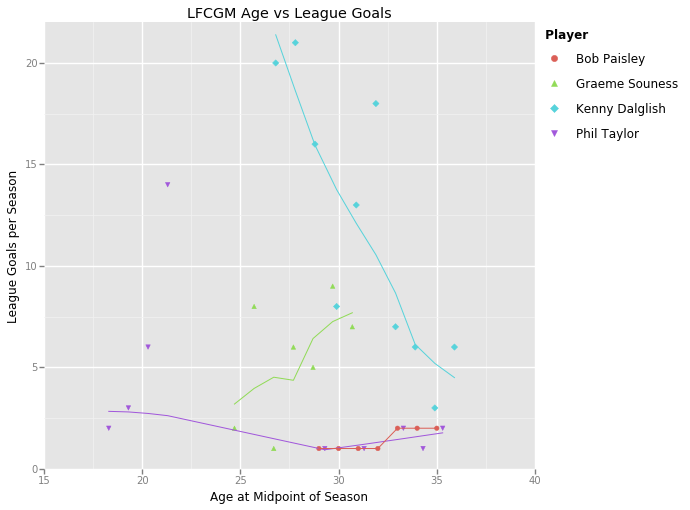

<ggplot: (11682241)>

In [83]:
players = df_mgrs.index.values
print players
ggplot_age_vs_lgoals(dflfc_scorers_tl_pos_age, list(players))

Top midfielders

In [84]:
# show midfielders who have scored more than 15 goals
df_mids = dflfc_scorers_tl_pos_age[(dflfc_scorers_tl_pos_age.position == 'Midfielder') &
                                    (dflfc_scorers_tl_pos_age.league > 15)].sort_values('league', ascending=False)
df_mids

,season,player,league,position,age
700,1951-1952,Billy Liddell,19,Midfielder,30.0
393,1984-1985,John Wark,18,Midfielder,27.4
418,1982-1983,Kenny Dalglish,18,Midfielder,31.9
723,1949-1950,Billy Liddell,17,Midfielder,28.0
839,1931-1932,Gordon Gunson,17,Midfielder,27.5
96,2008-2009,Steven Gerrard,16,Midfielder,28.6
327,1990-1991,John Barnes,16,Midfielder,27.2
876,1928-1929,Dick Edmed,16,Midfielder,24.9


7 ['Billy Liddell' 'John Wark' 'Kenny Dalglish' 'Gordon Gunson'
 'Steven Gerrard' 'John Barnes' 'Dick Edmed']


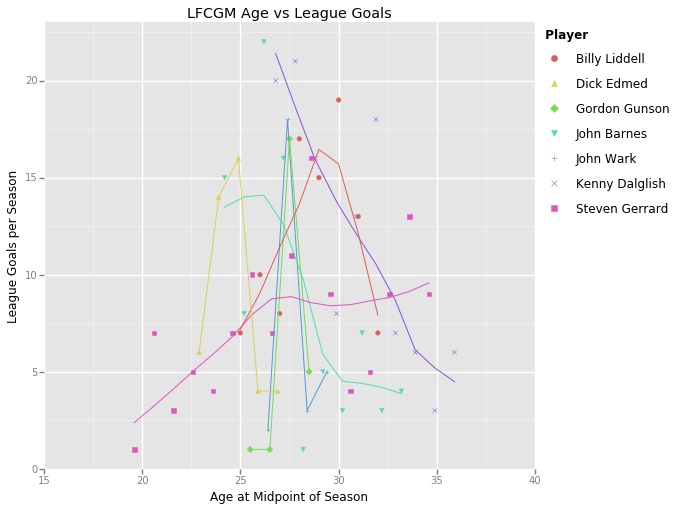

<ggplot: (15066228)>

In [85]:
players = df_mids.sort_values('league', ascending=False).player.unique()
print len(players), players
ggplot_age_vs_lgoals(dflfc_scorers_tl_pos_age, list(players))

Top Defenders

In [86]:
# show defenders who have scored more than 6 goals
df_defs = dflfc_scorers_tl_pos_age[(dflfc_scorers_tl_pos_age.position == 'Defender') &
                                    (dflfc_scorers_tl_pos_age.league > 6)].sort_values('league', ascending=False)
df_defs

,season,player,league,position,age
578,1969-1970,Chris Lawler,10,Defender,26.2
420,1982-1983,Phil Neal,8,Defender,31.9
36,2013-2014,Martin Skrtel,7,Defender,29.1
188,2001-2002,John Arne Riise,7,Defender,21.3
492,1976-1977,Phil Neal,7,Defender,25.9


4 ['Chris Lawler' 'Phil Neal' 'Martin Skrtel' 'John Arne Riise']


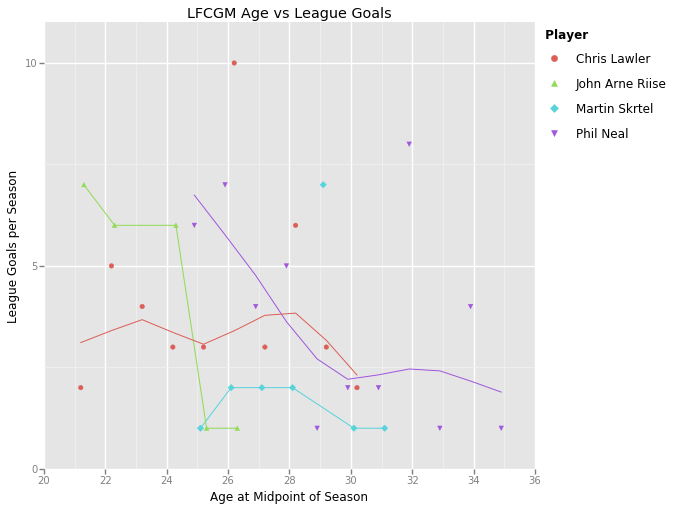

<ggplot: (11922096)>

In [87]:
players = df_defs.sort_values('league', ascending=False).player.unique()
print len(players), players
ggplot_age_vs_lgoals(dflfc_scorers_tl_pos_age, list(players))

Peak Performance

In [88]:
# show player with top score in a season, Gordon Hodgson
top_player = dflfc_scorers_tl_pos_age[dflfc_scorers_tl_pos_age.league == max(dflfc_scorers_tl_pos_age.league)]
top_player

,season,player,league,position,age
849,1930-1931,Gordon Hodgson,36,Striker,26.7


['Gordon Hodgson']


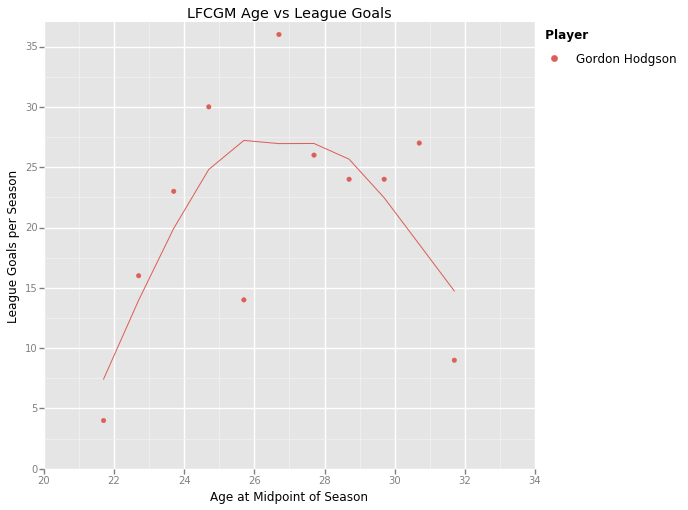

<ggplot: (15169947)>

In [89]:
players = top_player.player.values
print players
ggplot_age_vs_lgoals(dflfc_scorers_tl_pos_age, list(players))

Rocket Men

Show the players scored over 50  goals in 3 or more consecutive seasons, with a rising number of goals each season.

In [90]:
# create dataframe ordered by player and season
df = dflfc_scorers_tl_pos_age.groupby(['player', 'season']).sum()
df.head(12)

league   age
player          season                 
Abel Xavier     2001-2002       1  29.1
Abraham Hartley 1897-1898       1  25.9
Adam Lallana    2014-2015       5  26.7
                2015-2016       4  27.7
Alan A'Court    1952-1953       2  18.3
                1953-1954       3  19.3
                1962-1963       2  28.3
Alan Arnell     1953-1954       1  20.1
Alan Hansen     1978-1979       1  23.6
                1979-1980       4  24.6
                1980-1981       1  25.6
                1983-1984       1  28.6

In [91]:
def linefit(x, y):
    """"Return gradient and intercept of straight line of best fit for given x and y arrays."""
    gradient, intercept = np.polyfit(x, y, 1)
    return gradient, intercept

[-1  0  1  2]
[ 8  6  8 14]
2.0 8.0


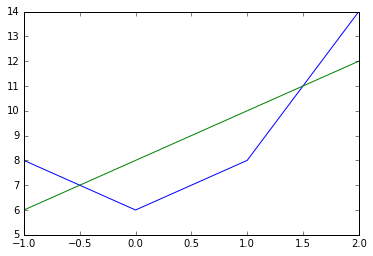

In [92]:
# test linefit()
# using y = 2x^2 + 6
x=np.array([-1, 0, 1, 2])
print x
y=2*x*x + 6
print y
print plt.plot(x, y)
gradient, intercept = linefit(x, y)
print np.round(gradient, 1), np.round(intercept, 1)
print plt.plot(x, gradient*x + intercept)

In [93]:
# Show the players scored over 50 goals in 3 or more consecutive seasons, with a rising number of goals each season.
MIN_SEASONS = 3
MIN_TOTAL_GOALS = 50
p_prev = None # previous player
l_prev = None # previous league goals
Lg = [] # List of consecutive goals
La = [] # List of consecutive ages
Ls = [] # List of consecutive seasons

# iterate through dataframe 
# for each row of (player, season) (league goals, age)
for (p, s), (l, a) in df.iterrows():
    if p != p_prev:
        # new player, so check previous
        if len(Lg) >= MIN_SEASONS and sum(Lg) >= MIN_TOTAL_GOALS:
            grad, intercept = linefit(np.array(range(len(Lg))), np.array(Lg))
            print 'Rocket man: {}, goals={}, start_season={}, start_age={}, goals={}, grad={}'\
                                .format(p_prev, Lg, Ls[0], La[0], sum(Lg), np.round(grad, 2))
            
        #print 'new p', p
        l_prev = None
        Lg = []
        La = []
        Ls = []
        
    # print p, s, l, a #player, season, league, age
    #print l, l_prev, Lg
    if l >= l_prev:
        #print '\t', l, 'greater than', l_prev, Lg
        Lg.append(l)
        La.append(a)
        Ls.append(s)
    else:
        if len(Lg) >= MIN_SEASONS and sum(Lg) >= MIN_TOTAL_GOALS:
            grad, intercept = linefit(np.array(range(len(Lg))), np.array(Lg))
            print 'Rocket man: {}, goals={}, start_season={}, start_age={}, goals={}, grad={}'\
                                .format(p_prev, Lg, Ls[0], La[0], sum(Lg), np.round(grad, 2))
        Lg = [l]
        La = [a]
        Ls = [s]
    
    l_prev = l
    p_prev = p
            

Rocket man: Berry Nieuwenhuys, goals=[9.0, 10.0, 10.0, 13.0, 13.0, 14.0], start_season=1933-1934, start_age=22.2, goals=69.0, grad=1.06
Rocket man: Dick Forshaw, goals=[7.0, 9.0, 17.0, 19.0], start_season=1919-1920, start_age=24.4, goals=52.0, grad=4.4
Rocket man: Dick Forshaw, goals=[5.0, 19.0, 27.0], start_season=1923-1924, start_age=28.4, goals=51.0, grad=11.0
Rocket man: Gordon Hodgson, goals=[4.0, 16.0, 23.0, 30.0], start_season=1925-1926, start_age=21.7, goals=73.0, grad=8.5
Rocket man: Gordon Hodgson, goals=[24.0, 24.0, 27.0], start_season=1932-1933, start_age=28.7, goals=75.0, grad=1.5
Rocket man: Ian Rush, goals=[17.0, 24.0, 32.0], start_season=1981-1982, start_age=20.2, goals=73.0, grad=7.5
Rocket man: Ian Rush, goals=[14.0, 22.0, 30.0], start_season=1984-1985, start_age=23.2, goals=66.0, grad=8.0
Rocket man: Luis Suarez, goals=[4.0, 11.0, 23.0, 31.0], start_season=2010-2011, start_age=24.0, goals=69.0, grad=9.3
Rocket man: Michael Owen, goals=[11.0, 16.0, 19.0, 19.0], start_

Top 5 Rocket Men (sorted by gradient of line of best fit) are
- Dick Forshaw, 11
- Luis Suarez, 9.3
- Gordon Hodgson, 8.5
- Ian Rush, 8.0
- Robbie Fowler, 8.0

        season         player  league position   age
263  1995-1996  Robbie Fowler      28  Striker  20.7
273  1994-1995  Robbie Fowler      25  Striker  19.7
283  1993-1994  Robbie Fowler      12  Striker  18.7


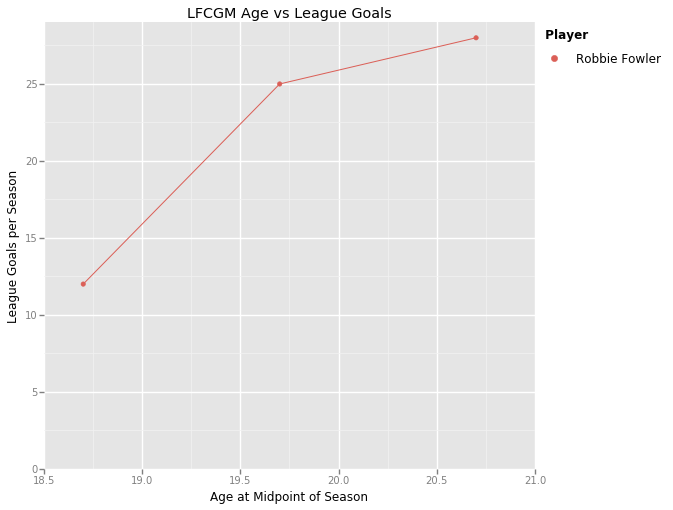

<ggplot: (14514047)>


In [94]:
# show example graph of the rocket portion of the players career e.g. Robbie Fowler
p = 'Robbie Fowler'
Lg = [12.0, 25.0, 28.0]
dfp = dflfc_scorers_tl_pos_age[(dflfc_scorers_tl_pos_age.player == p) &
                               (dflfc_scorers_tl_pos.league.isin(Lg))]
print dfp
print ggplot_age_vs_lgoals(dfp, [p])

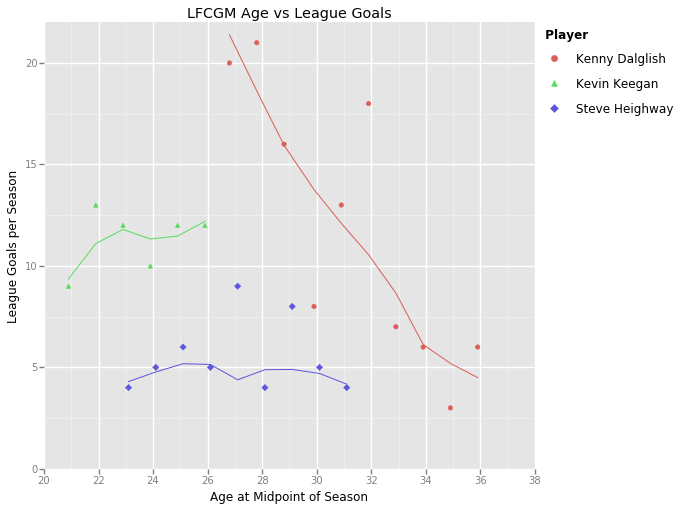

<ggplot: (11550005)>

In [95]:
# Just a few of my early favourites
players = ['Kevin Keegan', 'Kenny Dalglish', 'Steve Heighway']
ggplot_age_vs_lgoals(dflfc_scorers_tl_pos_age, players)

Highest scoring midfielders over career

player
Steven Gerrard       120
Billy Liddell         96
Berry Nieuwenhuys     74
Arthur Goddard        65
Jack Cox              62
John Barnes           62
Terry McDermott       54
Name: league, dtype: int64
7


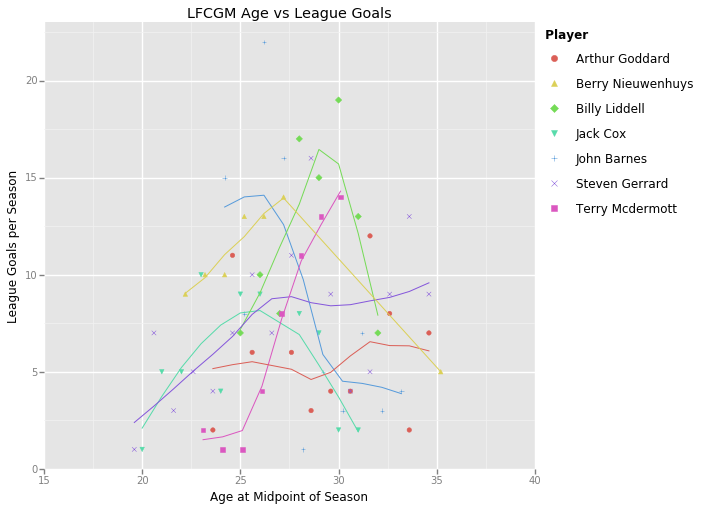

<ggplot: (11658952)>

In [96]:
df = dflfc_scorers_tl_pos_age[(dflfc_scorers_tl_pos_age.position == 'Midfielder')]\
                            .groupby('player').sum()
print df[df.league > 50].sort_values('league', ascending=False)['league']
players = df[df.league > 50].sort_values('league', ascending=False).index.unique()
print len(players)
ggplot_age_vs_lgoals(dflfc_scorers_tl_pos_age, list(players))

Highest scoring defenders over career

player
Chris Lawler        41
Phil Neal           41
Tommy Smith         36
Donald Mackinlay    28
Steve Nicol         23
Sami Hyypia         22
John Arne Riise     21
Name: league, dtype: int64
7


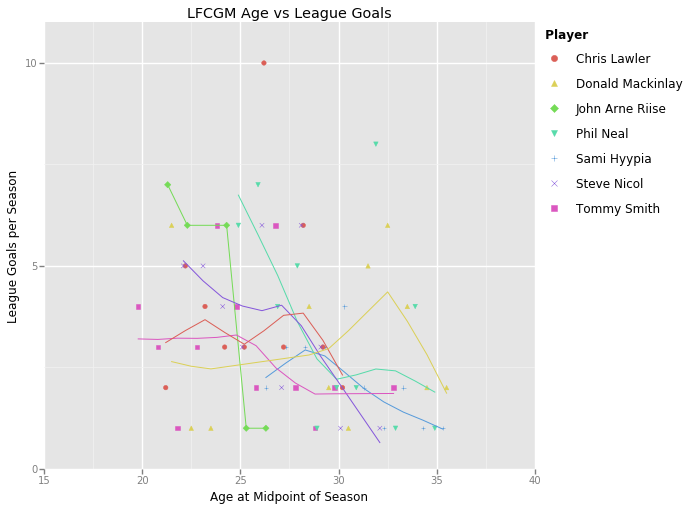

<ggplot: (14509803)>

In [97]:
df = dflfc_scorers_tl_pos_age[(dflfc_scorers_tl_pos_age.position == 'Defender')]\
                            .groupby('player').sum()
print df[df.league > 20].sort_values('league', ascending=False)['league']
players = df[df.league > 20].sort_values('league', ascending=False).index.unique()
print len(players)
ggplot_age_vs_lgoals(dflfc_scorers_tl_pos_age, list(players))

The Champions

In [98]:
# create list of seasons when LFC were champions
CHAMPS = ['1900-1901', '1905-1906', '1921-1922', '1922-1923', '1946-1947', '1963-1964',\
          '1965-1966', '1972-1973', '1975-1976', '1976-1977', '1978-1979', '1979-1980',\
          '1981-1982', '1982-1983', '1983-1984', '1985-1986', '1987-1988', '1989-1990']
print len(CHAMPS)

18


In [99]:
# show total goals over career in title winning teams
df_champs = dflfc_scorers_tl_pos_age[dflfc_scorers_tl_pos_age.season.isin(CHAMPS)][['league', 'player']].groupby('player').sum()\
                            .sort_values('league', ascending=False).head(12)
df_champs

,league
player,
Ian Rush,113
Kenny Dalglish,78
Roger Hunt,60
David Johnson,44
Harry Chambers,41
John Toshack,39
John Barnes,37
Kevin Keegan,37
Dick Forshaw,36


['Ian Rush' 'Kenny Dalglish' 'Roger Hunt' 'David Johnson' 'Harry Chambers'
 'John Toshack' 'John Barnes' 'Kevin Keegan']


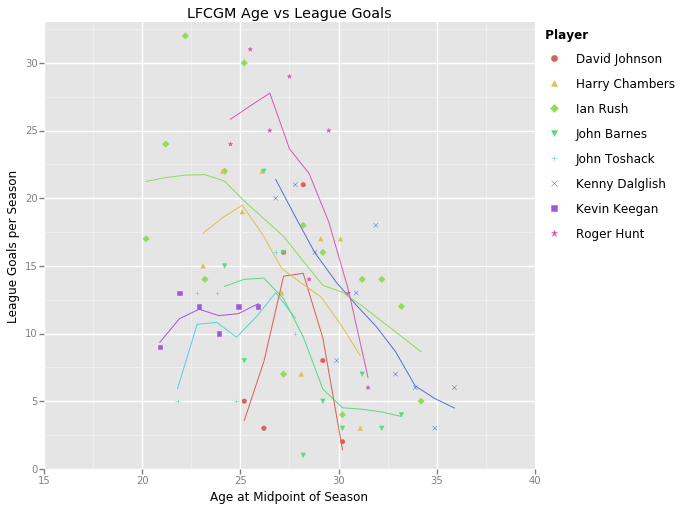

<ggplot: (11473826)>

In [100]:
# plot top 8
players = df_champs.index.values[:8]
print players
ggplot_age_vs_lgoals(dflfc_scorers_tl_pos_age, list(players))

In [101]:
# show highest scorers in a title winning season
dflfc_scorers_tl_pos_age[dflfc_scorers_tl_pos_age.season.isin(CHAMPS)].sort_values('league', ascending=False).head(12)

,season,player,league,position,age
405,1983-1984,Ian Rush,32,Striker,22.2
654,1963-1964,Roger Hunt,31,Striker,25.5
627,1965-1966,Roger Hunt,29,Striker,27.5
358,1987-1988,John Aldridge,26,Striker,29.3
755,1946-1947,Albert Stubbins,24,Striker,27.5
754,1946-1947,Jack Balmer,24,Striker,30.9
1089,1905-1906,Joe Hewitt,24,Striker,24.7
417,1982-1983,Ian Rush,24,Striker,21.2
336,1989-1990,John Barnes,22,Striker,26.2
379,1985-1986,Ian Rush,22,Striker,24.2


European Cup Winning Team, May 1977

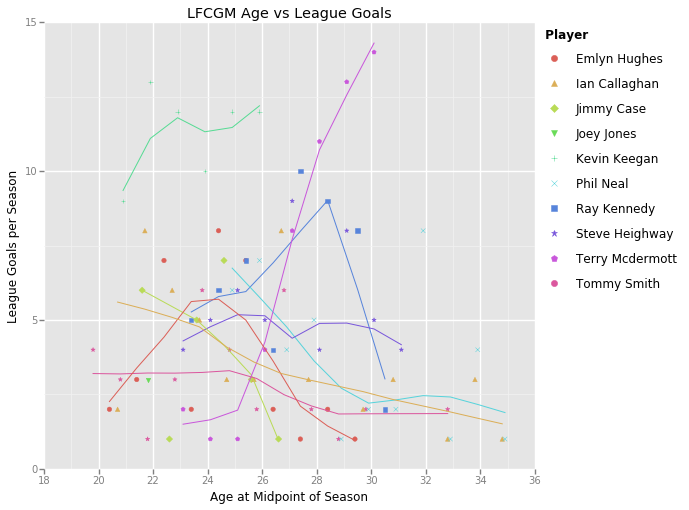

<ggplot: (11694747)>

In [102]:
players = ['Ray Clemence', 'Phil Neal', 'Joey Jones', 'Tommy Smith',
           'Ray Kennedy', 'Emlyn Hughes', 'Kevin Keegan', 'Jimmy Case',
           'Steve Heighway', 'Ian Callaghan', 'Terry McDermott']
ggplot_age_vs_lgoals(dflfc_scorers_tl_pos_age, players)

Best goals per game

In [113]:
# calculate GPG for each player season
dflfc_scorers_tl_pos_age_apps['GPG'] = (dflfc_scorers_tl_pos_age_apps.league/dflfc_scorers_tl_pos_age_apps.lgapp).round(3)

In [114]:
dflfc_scorers_tl_pos_age_apps.head()

,season,player,league,position,age,lgapp,GPG
0,2015-2016,Roberto Firmino,10,Striker,24.3,31,0.323
1,2015-2016,Christian Benteke,9,Striker,25.1,29,0.310
2,2015-2016,Daniel Sturridge,8,Striker,26.4,14,0.571
3,2015-2016,Philippe Coutinho,8,Midfielder,23.6,26,0.308
4,2015-2016,Divock Origi,5,Striker,20.7,16,0.312


In [115]:
# show best GPG per season where appearance > 10
dflfc_scorers_tl_pos_age_apps[dflfc_scorers_tl_pos_age_apps.lgapp > 10].sort_values('GPG', ascending=False).head(15)

,season,player,league,position,age,lgapp,GPG
1045,1909-1910,Jack Parkinson,30,Striker,26.3,31,0.968
1116,1902-1903,Sam Raybould,31,Striker,27.6,33,0.939
32,2013-2014,Luis Suarez,31,Striker,27.0,33,0.939
849,1930-1931,Gordon Hodgson,36,Striker,26.7,40,0.900
910,1925-1926,Dick Forshaw,27,Striker,30.4,32,0.844
985,1914-1915,Fred Pagnam,24,Striker,23.3,29,0.828
85,2009-2010,Fernando Torres,18,Striker,25.8,22,0.818
802,1934-1935,Gordon Hodgson,27,Striker,30.7,34,0.794
875,1928-1929,Gordon Hodgson,30,Striker,24.7,38,0.789
627,1965-1966,Roger Hunt,29,Striker,27.5,37,0.784


In [125]:
# show best Career GPG (CGPG) per career where appearance > 50
df_gpg = dflfc_scorers_tl_pos_age_apps[['player', 'league', 'lgapp']].groupby('player').sum()
df_gpg['CGPG'] = (df_gpg.league/df_gpg.lgapp).round(3) # career goals per game
df_gpg['CMPG'] = (df_gpg.lgapp*90/df_gpg.league).round(3) # career minutes per goal (assume all apps = 90 mins)
df_gpg[df_gpg.lgapp > 50].sort_values('CGPG', ascending=False).head(12)

,league,lgapp,CGPG,CMPG
player,,,,
Gordon Hodgson,233,358,0.651,138.283
Fernando Torres,65,102,0.637,141.231
Luis Suarez,69,110,0.627,143.478
Daniel Sturridge,43,69,0.623,144.419
Jimmy Smith,38,61,0.623,144.474
John Aldridge,50,83,0.602,149.400
Tom Reid,30,51,0.588,153.000
Jack Parkinson,103,178,0.579,155.534
Roger Hunt,167,295,0.566,158.982


['Gordon Hodgson' 'Fernando Torres' 'Luis Suarez' 'Daniel Sturridge'
 'Jimmy Smith' 'John Aldridge']


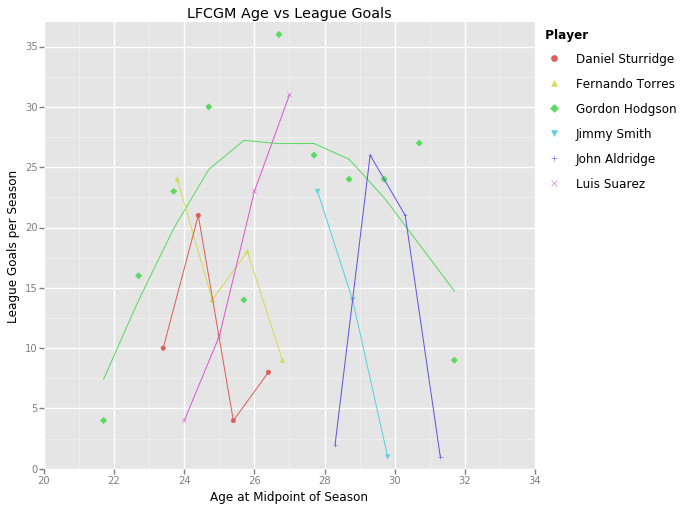

<ggplot: (11931249)>

In [126]:
# plot top 6 goal scorers with best Career GPG
players = df_gpg[df_gpg.lgapp > 50].sort_values('CGPG', ascending=False).head(6).index.values
print players
ggplot_age_vs_lgoals(dflfc_scorers_tl_pos_age, list(players))

## Note on the variable number of games per season

Note that the number of league games has varied over the top level seasons.

In [127]:
# show number of different total games
print dflfc_league[dflfc_league.League.isin(['1st Division', 'Premier League'])].PLD.unique()

[30 34 38 42  3 40]


In [128]:
# show number of seasons for each total
dflfc_league[dflfc_league.League.isin(['1st Division', 'Premier League'])][['PLD', 'Season']].groupby('PLD').count()

,Season
PLD,
3,1
30,3
34,6
38,34
40,1
42,57


In [129]:
# show the seasons for each total
dflfc_league[dflfc_league.League.isin(['1st Division', 'Premier League'])][['PLD', 'Season']]\
                        .groupby('PLD')['Season'].apply(lambda x: ','.join(x))

PLD
3                                             1939-1940
30                        1894-1895,1896-1897,1897-1898
34    1898-1899,1899-1900,1900-1901,1901-1902,1902-1...
38    1905-1906,1906-1907,1907-1908,1908-1909,1909-1...
40                                            1987-1988
42    1919-1920,1920-1921,1921-1922,1922-1923,1923-1...
Name: Season, dtype: object

In [130]:
# confirm that season 1939-1940 is not included in analysis
len(dflfc_scorers_tl_pos_age[dflfc_scorers_tl_pos_age.season == '1939-1940'])

0

## Building The Spyre App

Useful reference material:
+ How to develop a Spyre app, including tutorials - [https://github.com/adamhajari/spyre](https://github.com/adamhajari/spyre).

Spyre is a web app framework for providing a simple user interface for Python data projects. In simple terms the app involves:
1. creating a user interface to capture the list of players.
2. calling the ggplot_age_vs_lgoals() function to plot the players' graph.

See [lfcgm_app.py in the lfcgm github repo](https://github.com/terrydolan/lfcgm) for the app source code.

#### Create the dropdown list of players for the Spyre app

I protyped using the checkbox for Spyre app input but decided multiple dropdowns was more elegant for my use case.

Note: ggplot does not plot single points correctly, so I decided to restrict the list of players to those who've scored in more than 1 season. For more information on the issue see [this stackoverflow question](http://stackoverflow.com/questions/35096626/x-axis-value-not-correct-for-ggplot-scatter-plot-with-a-single-point).

In [131]:
# create dataframe of all players who have scored 1 or more goals in more than 1 season
df_pgoals = dflfc_scorers_tl_pos_age[['player', 'age']].groupby('player').count()
df_pgoals.columns = ['goal_tot']
print df_pgoals.head(10)

print '\nThere are {} goal scorers.'.format(len(df_pgoals))
print "That's {} data points.".format(df_pgoals.sum().values[0])
print 'Of these {} have scored more than once.'.format(df_pgoals[df_pgoals.goal_tot > 1].count().values[0])
print "That's {} data points.".format(df_pgoals[df_pgoals.goal_tot > 1].sum().values[0])

print '\nHere are the first of those scoring more than once...'
df_pgoals_gt1 = df_pgoals[df_pgoals.goal_tot > 1]
df_pgoals_gt1.head()

                 goal_tot
player                   
Abel Xavier             1
Abraham Hartley         1
Adam Lallana            2
Alan A'Court            3
Alan Arnell             1
Alan Hansen             5
Alan Kennedy            7
Alan Scott              1
Alan Waddle             1
Albert Pearson          1

There are 380 goal scorers.
That's 1198 data points.
Of these 237 have scored more than once.
That's 1055 data points.

Here are the first of those scoring more than once...


,goal_tot
player,
Adam Lallana,2
Alan A'Court,3
Alan Hansen,5
Alan Kennedy,7
Albert Stubbins,6


In [132]:
# produce dataframe of players for the Spyre dropdown and save to csv
# this csv will be read by the app
player_dd = df_pgoals_gt1.index.values
player_dd

# create dropdown dataframe (with label and value) and save to csv
df_dropdown = pd.DataFrame(player_dd, player_dd).reset_index()
df_dropdown.columns = (['label', 'value'])
print df_dropdown.head()

# save dropdown label and value to csv
LFCGM_DROPDOWN = os.path.relpath('data\lfcgm_app_dropdown.csv')
df_dropdown[['label', 'value']].to_csv(LFCGM_DROPDOWN, index=False)

             label            value
0     Adam Lallana     Adam Lallana
1     Alan A'Court     Alan A'Court
2      Alan Hansen      Alan Hansen
3     Alan Kennedy     Alan Kennedy
4  Albert Stubbins  Albert Stubbins


In [ ]:
# show players added in latest season
LATEST_SEASON = '2015-2016'
scorers_for_latest_season_set = set(dflfc_scorers_tl[dflfc_scorers_tl.season == LATEST_SEASON].player.values)
this_season_scorers_df = dflfc_scorers_tl[dflfc_scorers_tl.player.isin(scorers_for_latest_season_set)]\
                                            [['player', 'season']].groupby('player').count()

players_added = this_season_scorers_df[this_season_scorers_df.season == 2].index.values
print 'there are {} new players added in {}; these are:'.format(len(players_added), LATEST_SEASON)
', '.join(players_added)

In [187]:
# read dropdown.csv and create dropdown _dict in format that the Spyre app will use
dropdown_df = pd.read_csv(LFCGM_DROPDOWN)
print dropdown_df.head(), '\n'

# create dict in format Spyre app will use
dropdown_dict = dropdown_df.to_dict(orient='records')

# check length of dict (expect 237)
# 233 + 4 players added in 2015-16: 
len(dropdown_dict)

# show 4 new players
dropdown_df[dropdown_df.value.isin(players_added)]

             label            value
0     Adam Lallana     Adam Lallana
1     Alan A'Court     Alan A'Court
2      Alan Hansen      Alan Hansen
3     Alan Kennedy     Alan Kennedy
4  Albert Stubbins  Albert Stubbins 



,label,value
0,Adam Lallana,Adam Lallana
5,Alberto Moreno,Alberto Moreno
68,Emre Can,Emre Can
161,Mamadou Sakho,Mamadou Sakho


#### Explore 'facet grid' of individual player graphs for those players in the dropdown

A final bit of data analysis to help find interesting plots...

In [188]:
# create grouper function to iterate in chunks of n
# ref: http://stackoverflow.com/questions/8991506/iterate-an-iterator-by-chunks-of-n-in-python
import string
from itertools import izip_longest
def grouper(n, iterable, fillvalue=None):
    "grouper(3, 'ABCDEFG', 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return izip_longest(fillvalue=fillvalue, *args)

In [189]:
# test grouper
tmp = string.ascii_lowercase
for g in grouper(4, tmp, None):
    print g

('a', 'b', 'c', 'd')
('e', 'f', 'g', 'h')
('i', 'j', 'k', 'l')
('m', 'n', 'o', 'p')
('q', 'r', 's', 't')
('u', 'v', 'w', 'x')
('y', 'z', None, None)


('Adam Lallana', "Alan A'Court", 'Alan Hansen', 'Alan Kennedy')


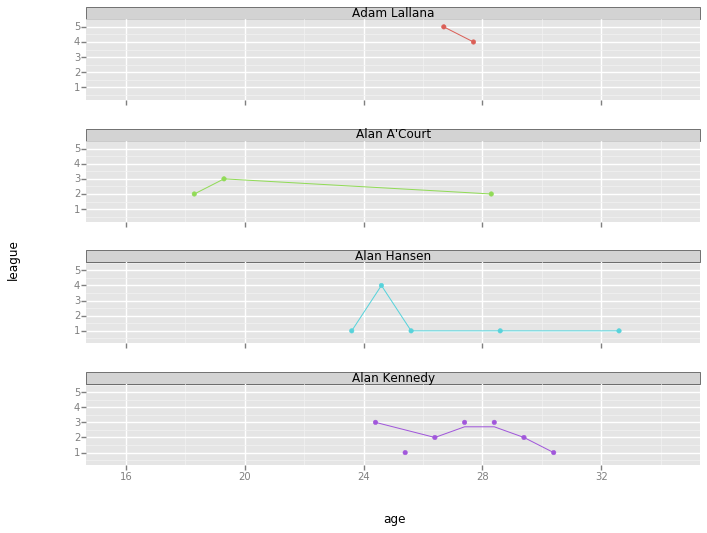

<ggplot: (11653289)>


In [190]:
# ggplot all players in group of 4
for players in grouper(4, player_dd, None):
    print players
    df = dflfc_scorers_tl_pos_age[dflfc_scorers_tl_pos_age.player.isin(players)][['age', 'league', 'player']]
    #print df
    print ggplot(df, aes(x='age', y='league', color='player')) + \
        geom_point() + \
        geom_smooth(se=False) + facet_grid('player')
    
    break # remove break to see all groups

#### Use of ggplot

I was keen to use ggplot because I intend to build an LFC Goal Machine equivalent in R Studio Shiny. Spyre is meant to make it easy to build Shiny-like apps so this should be straight-forward, right? Well, sort of. 

I've used ggplot in R and it is great. Yhat's python-ggplot is very good but still work in progress. I was able to get ggplot to produce the scatter plot and line of best fit but it was frustrating that I couldn't get ggplot to cope with single points, add annotations and only plot integer values (as half goals don't much make sense!). But ggplot was good enough.

#### Spyre App Deployment on Heroku

Reference Material:
+ How to deploy a Heroku python app - [https://devcenter.heroku.com/categories/python](https://devcenter.heroku.com/categories/python).
+ How to deploy a Spyre app on Heroku - [[http://adamhajari.github.io/2015/04/21/deploying-a-spyre-app-on-heroku.html](http://adamhajari.github.io/2015/04/21/deploying-a-spyre-app-on-heroku.html).

The biggest challenge was fitting the lfcgm app in Heroku's slug limit of 300 MB. lfcgm uses spyre, ggplot and pandas. These packages pull in other packages. Spyre uses numpy, pandas, cherrypy, jinja and matplotlib. Ggplot uses matplotlib, pandas, numpy, scipy, statsmodels and patsy. Pandas uses numpy, python-dateutil and pytz. This means that the size of the app and supporting packages is quite large. The biggest issue was scipy which needs to be built on Heroku.

I use the excellent [anaconda](https://www.continuum.io) for my python data analysis and development. So my first stab at building the Heroku app used [Kenneth Reitz' Heroku mini-conda buildpack](https://github.com/kennethreitz/conda-buildpack). Unfortunately the app slug size with this buildpack was much too big. 

Plan B (after lots of trial and error) used [Brandon Liu's scipy buildpack](https://github.com/thenovices/heroku-buildpack-scipy). This builds numpy and scipy. This allowed me to produce a compressed sluge size ~156 MB (phew).

The Heroku app's Procfile and requirements.txt are in the [lfcgm github repo](https://github.com/terrydolan/lfcgm).

#### Running the App

The app is available at [lfcgm.herokuapp.com](http://lfcgm.herokuapp.com).

It is also available at [lfcgm.lfcsorted.com](http://lfcgm.lfcsorted.com). See [here](https://devcenter.heroku.com/articles/custom-domains) for guidance on setting up a custom domain.

#### App Management

As an aside, Heroku has some great addons for managing the app e.g. papertrail for log management.

#### App Data

The LFC Goal Machine app uses the following data files:
+ data/lfcgm_app_dropdown.csv (used to build the dropdown list of players)
+ data/lfc_scorers_tl_pos_age.csv (used to build the pandas dataframe of LFC scorers in top level league)

The data structure of these files is described in this notebook. However the data is not in the lfcgm github repository because the data is owned by [lfchistory.net](http://www.lfchistory.net).

#### App Startup Times

Please be patient if the lfcgm app takes several seconds to wake-up. The entry level 'heroku dyno' has some key limitations:
- the dyno sleeps after a period of inactivity. 
- the dyno must sleep for 6 hours in each 24 hours period. 

If the lfcgm app doesn't respond please try again later.